In [1]:
# ruff: noqa: E402
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Util to import functions from project root
p = Path.cwd()
root = next(
    (
        parent
        for parent in [p] + list(p.parents)
        if (parent / "pyproject.toml").exists()
    ),
    None,
)
if root is None:
    root = Path.cwd()
sys.path.insert(0, str(root))

from src.model.data_processing import CustomColumnScaler, DataFrameTransformer


In [2]:
DATA_PATH = Path("../src/data/train_data.csv")
TARGET_COL = "reservation_status"
INCLUDE_WEEK_NUMBER_8TO10 = True

df_raw = pd.read_csv(DATA_PATH)
df_raw.head()


,Unnamed: 0,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,row_id
0,0,City Hotel,47,2016,March,13,20,2,2,2,...,D,0,No Deposit,0,Transient,85.00,0,0,2,0
1,1,Resort Hotel,221,2017,April,18,30,2,5,2,...,A,0,No Deposit,0,Transient-Party,71.43,0,0,1,1
2,2,City Hotel,11,2016,February,6,1,2,5,2,...,A,0,No Deposit,0,Transient,79.00,0,0,1,2
3,3,Resort Hotel,88,2015,November,48,28,2,4,2,...,A,0,No Deposit,0,Transient,32.40,0,0,1,3
4,4,Resort Hotel,250,2017,August,33,13,2,2,2,...,A,1,No Deposit,0,Transient,106.85,0,1,0,4


In [3]:
df = df_raw.copy()
if "row_id" in df.columns:
    df.set_index("row_id", inplace=True)
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
if INCLUDE_WEEK_NUMBER_8TO10 and "arrival_date_week_number" in df.columns:
    week_numbers = pd.to_numeric(df["arrival_date_week_number"], errors="coerce")
    df["is_week_number_8to10"] = ((week_numbers >= 8) & (week_numbers <= 10)).astype(
        int
    )

assert (df.isna().sum() == 0).all()

df.describe()


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,is_week_number_8to10
count,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000,68898.000000
mean,104.201878,2016.159424,27.113124,15.798572,0.930796,2.496981,1.856759,0.105010,0.008055,0.031888,0.090525,0.131005,0.219571,2.300894,102.039591,0.062106,0.569320,0.380519,0.054065
std,106.970199,0.705899,13.549977,8.777819,0.996605,1.895463,0.553997,0.401118,0.102690,0.175702,0.902800,1.505454,0.645983,17.472597,52.305946,0.244398,0.789934,0.505553,0.226148
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000
75%,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000,0.000000
max,709.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,50.000000,10.000000,10.000000,1.000000,26.000000,72.000000,17.000000,391.000000,5400.000000,8.000000,5.000000,2.000000,1.000000


In [4]:
df.dtypes


hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                     

In [5]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = [
    col for col in df.select_dtypes(include=[np.number]).columns if col != TARGET_COL
]
categorical_cols, numeric_cols



(['hotel',
  'arrival_date_month',
  'meal',
  'country',
  'market_segment',
  'distribution_channel',
  'reserved_room_type',
  'assigned_room_type',
  'deposit_type',
  'customer_type'],
 ['lead_time',
  'arrival_date_year',
  'arrival_date_week_number',
  'arrival_date_day_of_month',
  'stays_in_weekend_nights',
  'stays_in_week_nights',
  'adults',
  'children',
  'babies',
  'is_repeated_guest',
  'previous_cancellations',
  'previous_bookings_not_canceled',
  'booking_changes',
  'days_in_waiting_list',
  'adr',
  'required_car_parking_spaces',
  'total_of_special_requests',
  'is_week_number_8to10'])

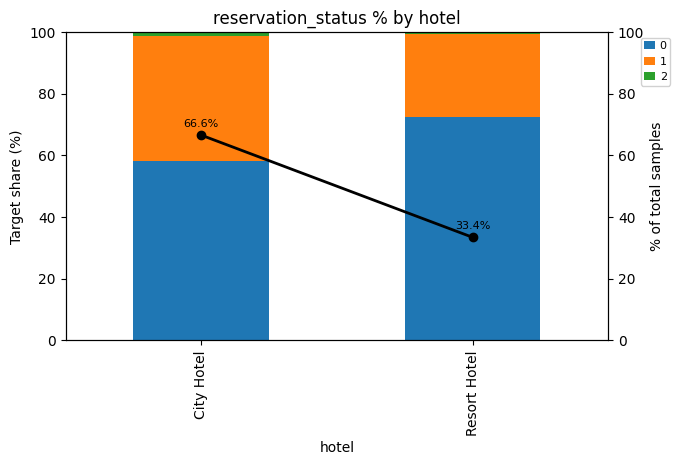

lead_time skipped (474 classes).


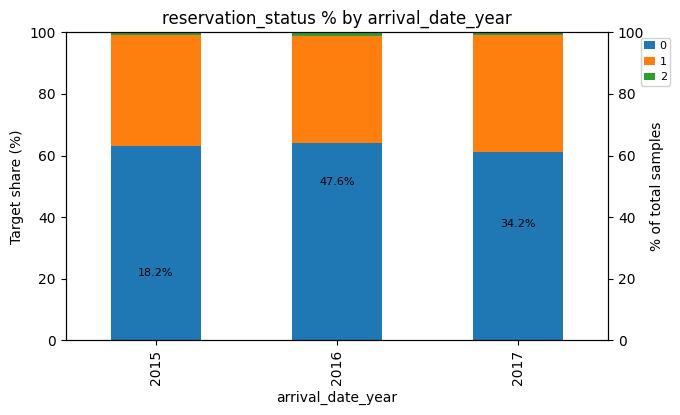

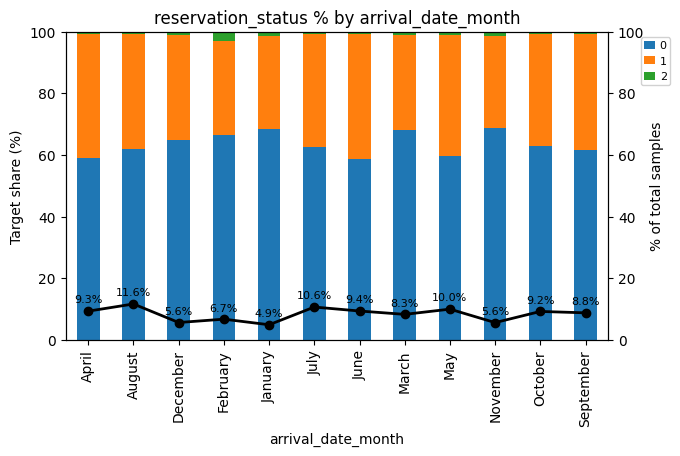

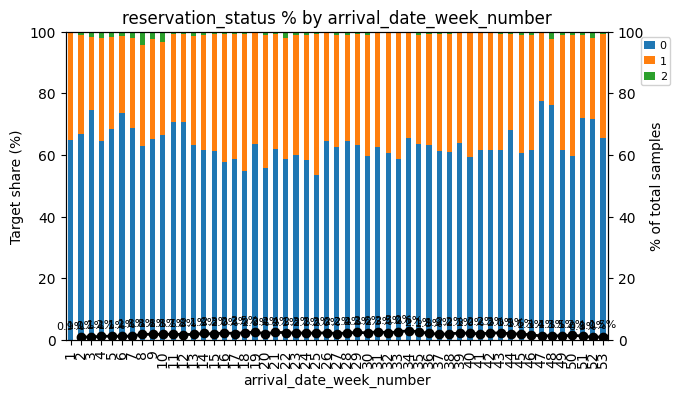

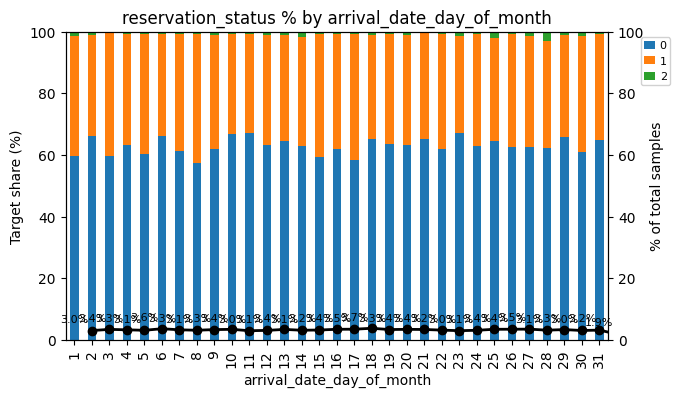

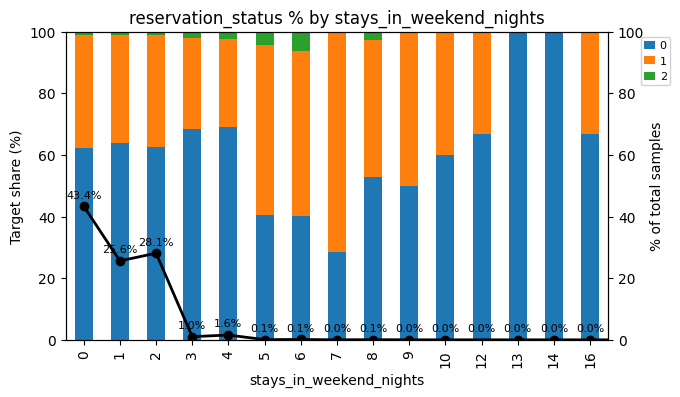

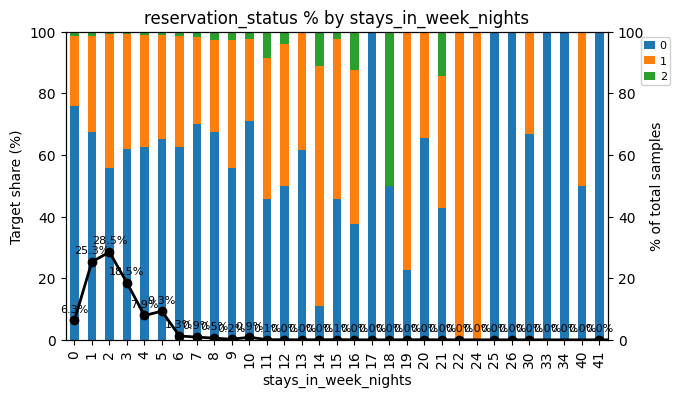

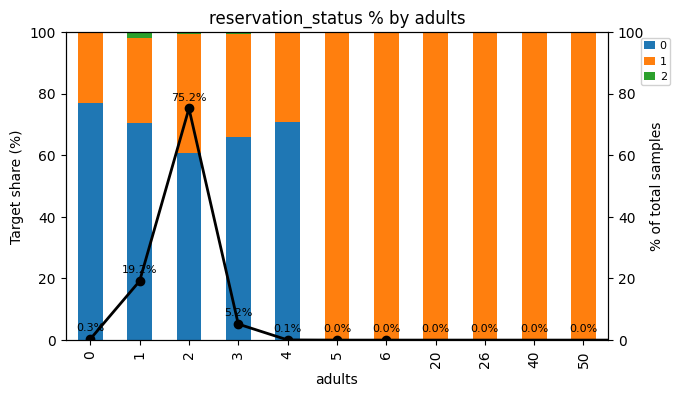

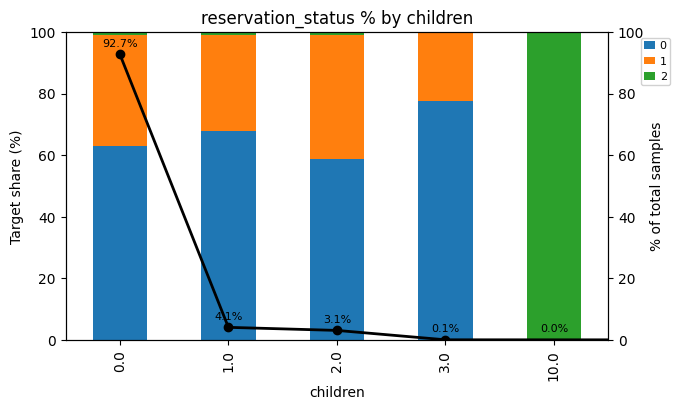

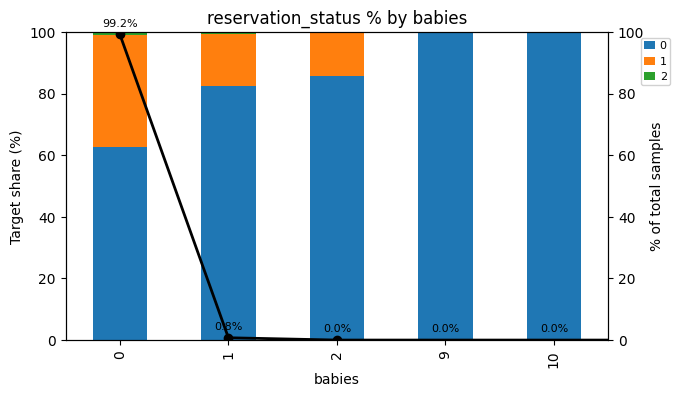

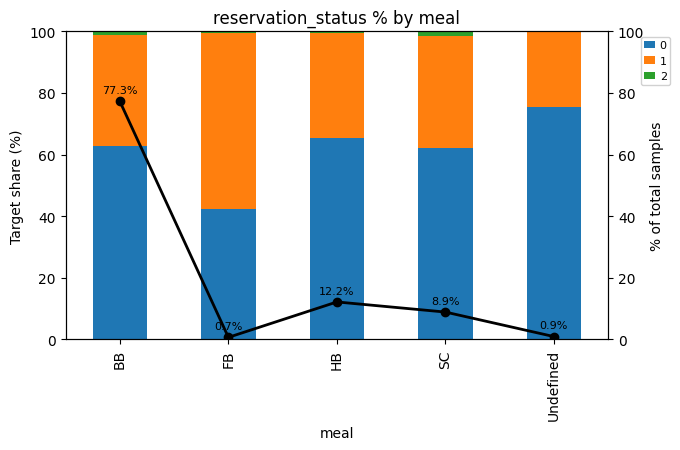

country skipped (162 classes).


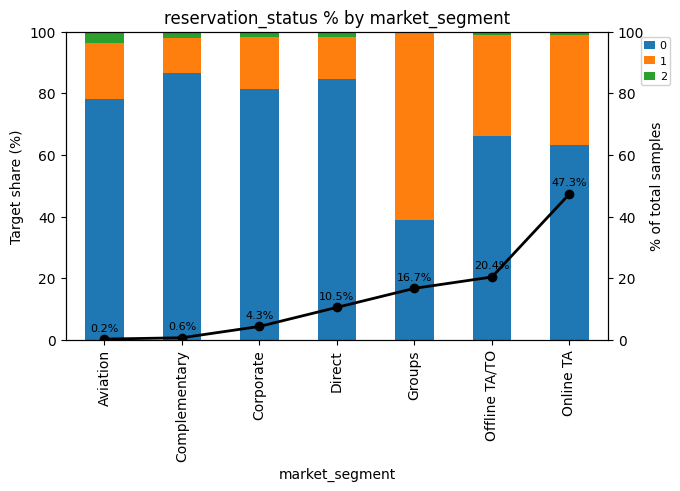

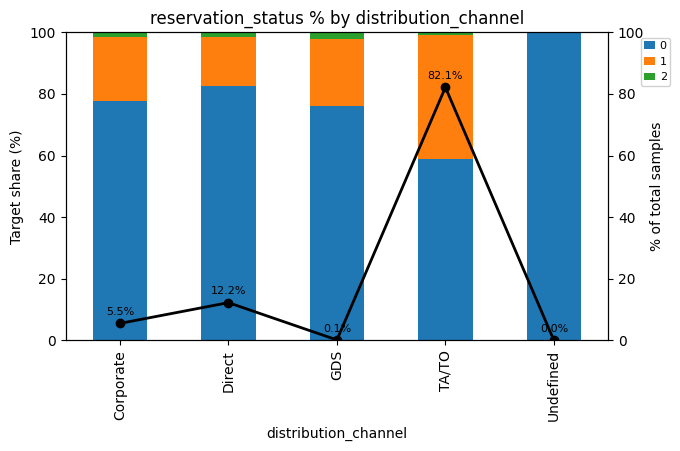

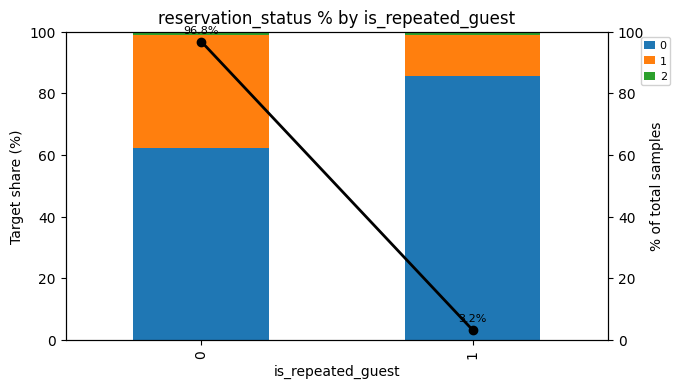

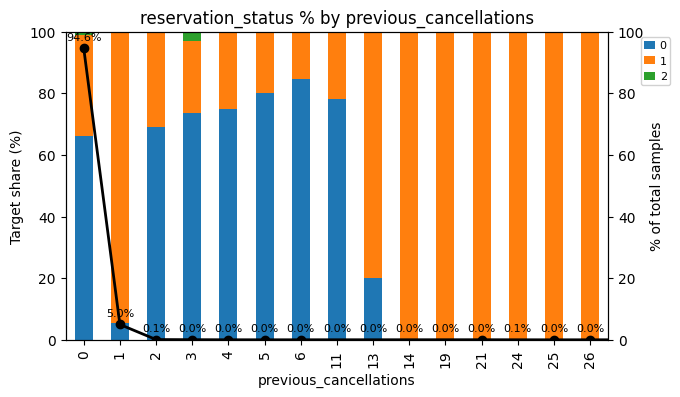

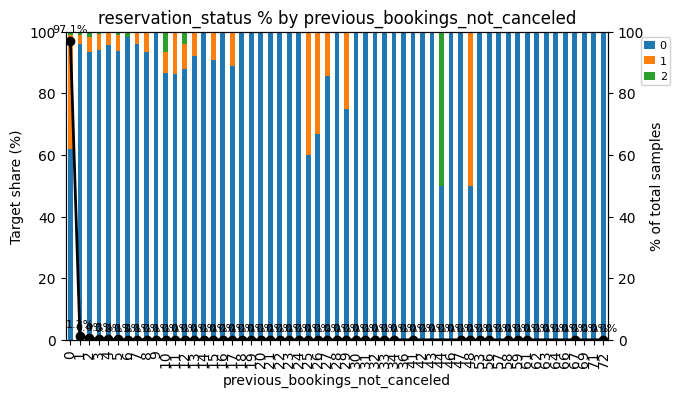

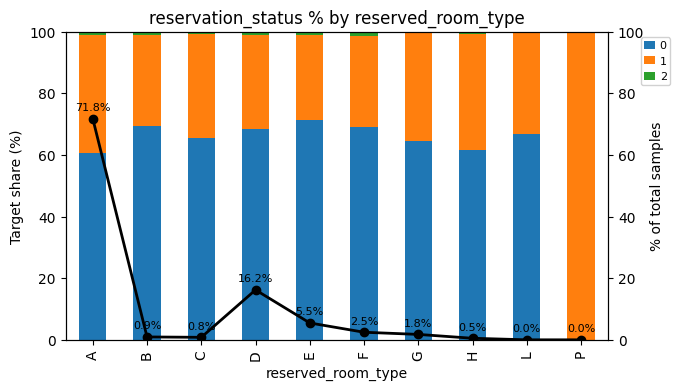

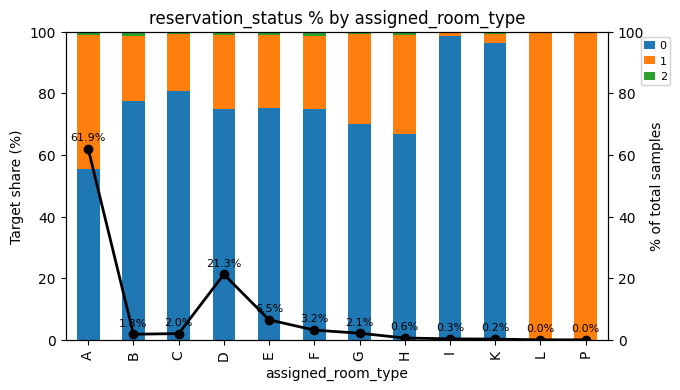

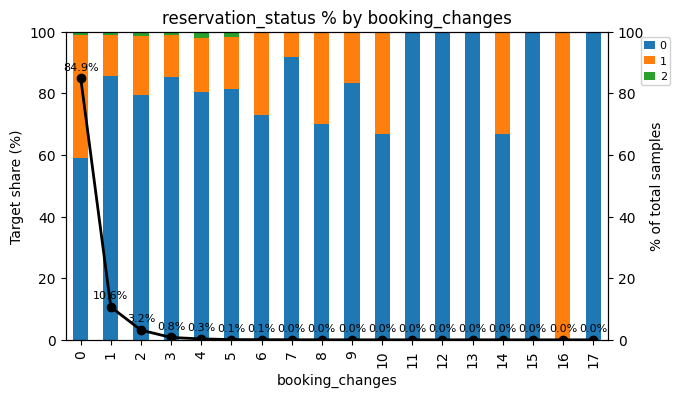

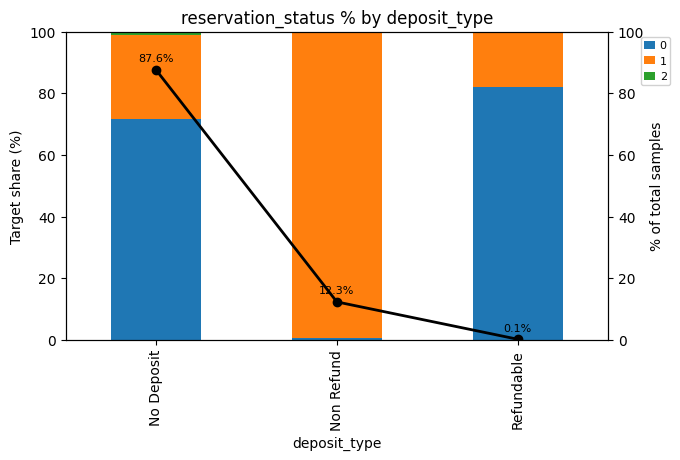

days_in_waiting_list skipped (116 classes).


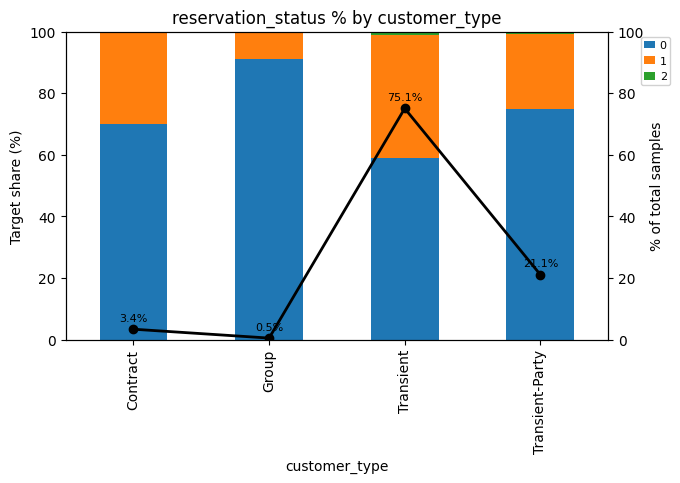

adr skipped (6800 classes).


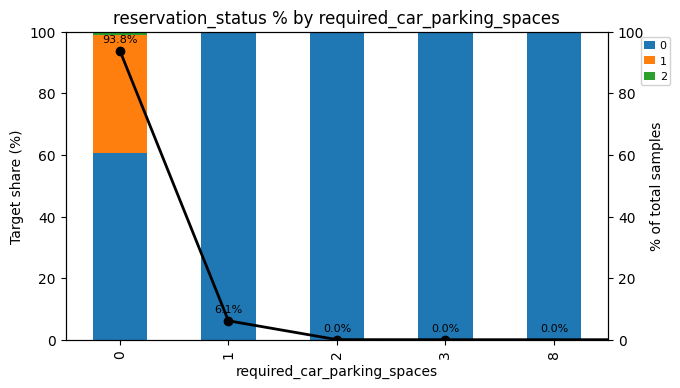

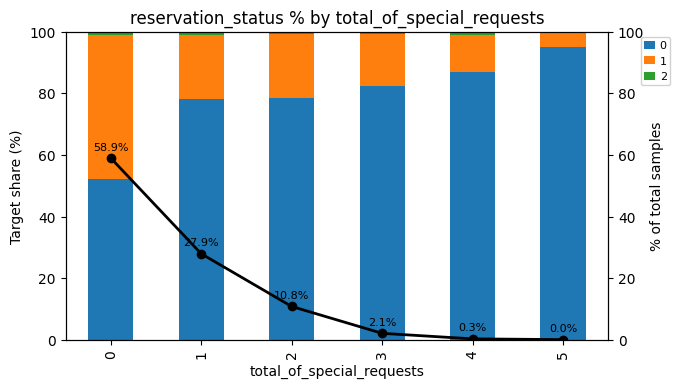

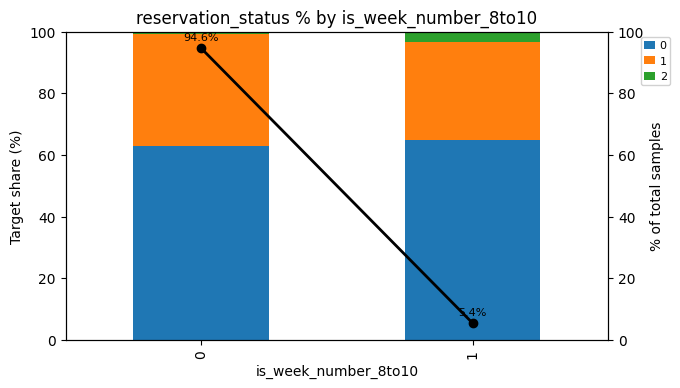

In [6]:
def plot_target_breakdown(
    data: pd.DataFrame,
    column: str,
    target: str = TARGET_COL,
    *,
    max_classes: int = 80,
) -> None:
    if column not in data.columns or column == target:
        return

    n_classes = data[column].nunique()
    if n_classes == 0 or n_classes > max_classes:
        print(f"{column} skipped ({n_classes} classes).")
        return

    target_pct = (
        data.groupby(column)[target]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        .multiply(100)
    )

    class_pct = (
        data[column]
        .value_counts(normalize=True)
        .multiply(100)
        .reindex(target_pct.index)
        .fillna(0)
    )

    ax = target_pct.plot(kind="bar", stacked=True, figsize=(7, 4))
    ax.set_title(f"{target} % by {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Target share (%)")
    ax.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        prop={"size": 8},
        handlelength=1,
        handletextpad=0.4,
        borderpad=0.3,
        framealpha=0.9,
    )
    ax.set_ylim(0, 100)

    ax2 = ax.twinx()
    class_pct.plot(kind="line", marker="o", color="k", ax=ax2, linewidth=2)
    ax2.set_ylabel("% of total samples")
    # ax2.set_ylim(0, max(100, class_pct.max() * 1.1))
    ax2.set_ylim(0, 100)

    for x, y in enumerate(class_pct.values):
        ax2.text(
            x,
            y + (ax2.get_ylim()[1] * 0.02),
            f"{y:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    plt.show()


for col in df.columns:
    plot_target_breakdown(df, col)


In [7]:
# Large class imbalance => Stratified cross-validation needed
target_pct = df[TARGET_COL].value_counts(normalize=True).multiply(100)
print("Overall reservation status %:")
for cls, pct in target_pct.sort_index().items():
    print(f"  {cls}: {pct:.2f}%")



Overall reservation status %:
  0: 62.94%
  1: 36.07%
  2: 0.99%


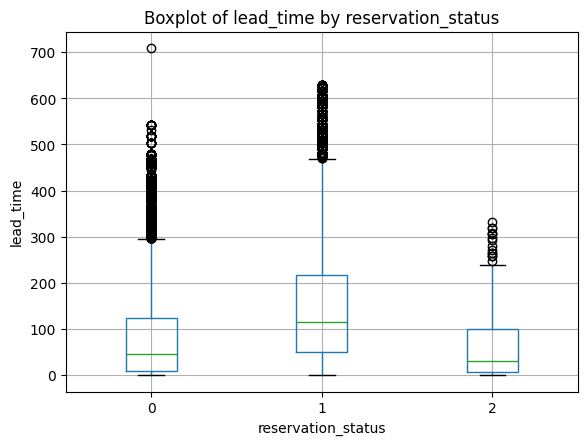

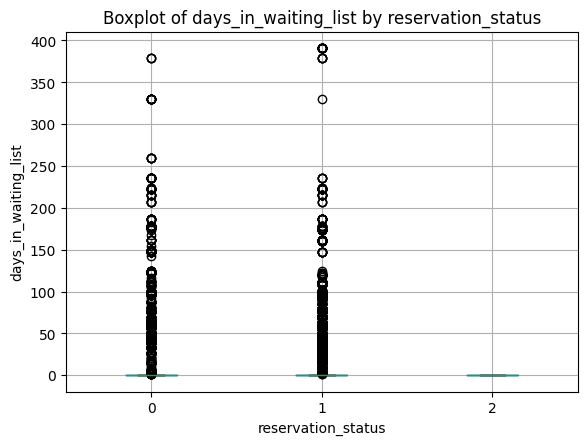

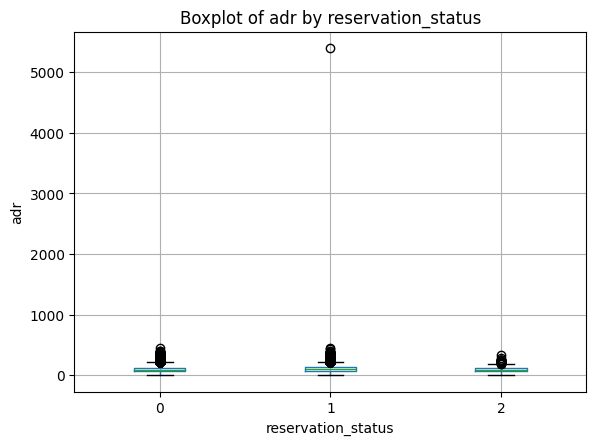

In [8]:
def plot_boxplot(column: str) -> None:
    if column not in df.columns:
        return
    df.boxplot(column=column, by=TARGET_COL)
    plt.title(f"Boxplot of {column} by {TARGET_COL}")
    plt.suptitle("")
    plt.xlabel(TARGET_COL)
    plt.ylabel(column)
    plt.show()


for col in ["lead_time", "days_in_waiting_list", "adr"]:
    plot_boxplot(col)


In [9]:
# Outlier with extremely high adr
adr_extremes = df[df["adr"] > 1000][["adr", TARGET_COL]]
adr_extremes


,adr,reservation_status
row_id,,
14237,5400.0,1


In [10]:
# Majority of customers are from PRT, we make the hypothesis that this is the home country.
df["country"].value_counts().head(10)


country
PRT    28154
GBR     7059
FRA     6049
ESP     4942
DEU     4260
ITA     2173
IRL     1942
BEL     1342
BRA     1285
USA     1244
Name: count, dtype: int64

In [11]:
# We apply multiple transformations to the data:
# - Treat `row_id` as an index so we do not leak unwanted information
# - We create a binary flag `is_city_hotel` instead of `hotel`
# - We create a variable `is_home_country` instead of `country` (here the home country is PRT), to avoid encoding numerous categorical variables, under the hypothesis that the customers from foreign countries behave similarly.
# - There is one `Undefined` value in `distribution_channel`, we replace it with the most common channel.
# - We create a binary flag `room_not_same_as_reserved` to capture potential dissatisfaction when the assigned room differs from the reserved one. Note: we could then drop the original columns `assigned_room_type` and `reserved_room_type`.
# - We create a binary flag `has_required_car_parking_spaces` to indicate whether the customer requested parking. (in the train set, every customer with a positive number for required_car_parking_spaces is of class 1).
# - Optionally, we create a binary flag `is_week_number_8to10` to highlight the 3 weeks with really high "no-show" rates.
# - Instead of month/week/day_of_month number, we encode day_of_year as cyclical features (sine and cosine) to capture seasonality.

df_transformer = DataFrameTransformer(
    include_week_number_8to10_flag=INCLUDE_WEEK_NUMBER_8TO10
)
df_transformed = df_transformer.fit_transform(df_raw)

df_raw.shape, df_transformed.shape


((68898, 30), (68897, 27))

In [12]:
df_transformed.head()


,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,...,adr,total_of_special_requests,reservation_status,is_city_hotel,is_home_country,room_not_same_as_reserved,has_required_car_parking_spaces,arrival_day_sin,arrival_day_cos,is_week_number_8to10
row_id,,,,,,,,,,,,,,,,,,,,,
0,47,2016,2,2,2,0.0,0,BB,Offline TA/TO,TA/TO,...,85.00,0,2,1,1,1,0,0.980575,0.196143,0
1,221,2017,2,5,2,0.0,0,HB,Groups,TA/TO,...,71.43,0,1,0,1,0,0,0.874481,-0.485060,0
2,11,2016,2,5,2,0.0,0,SC,Online TA,TA/TO,...,79.00,0,1,1,0,0,0,0.522133,0.852864,0
3,88,2015,2,4,2,0.0,0,BB,Online TA,TA/TO,...,32.40,0,1,0,1,0,0,-0.536696,0.843776,0
4,250,2017,2,2,2,0.0,0,BB,Offline TA/TO,TA/TO,...,106.85,1,0,0,0,0,0,-0.672949,-0.739689,0


In [13]:
df_transformed.columns.tolist()


['lead_time',
 'arrival_date_year',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'total_of_special_requests',
 'reservation_status',
 'is_city_hotel',
 'is_home_country',
 'room_not_same_as_reserved',
 'has_required_car_parking_spaces',
 'arrival_day_sin',
 'arrival_day_cos',
 'is_week_number_8to10']

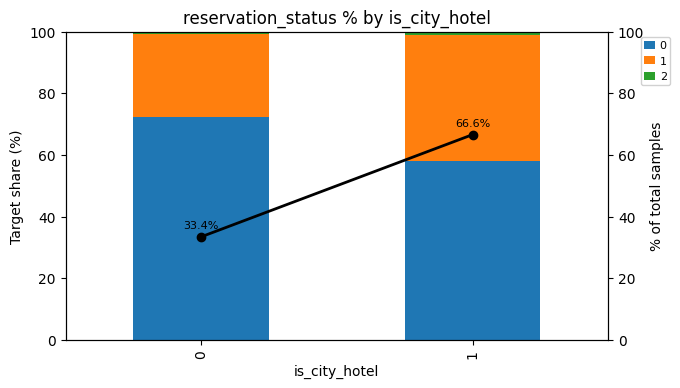

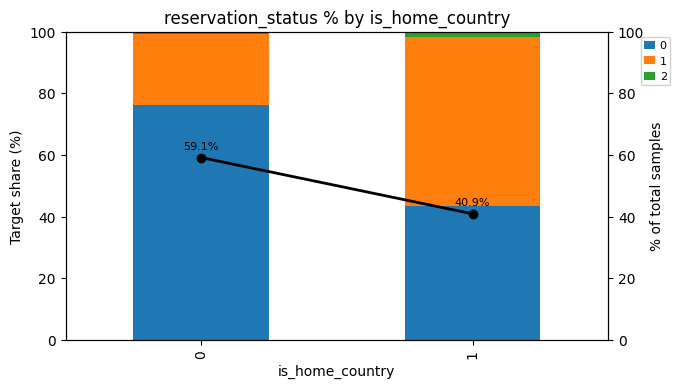

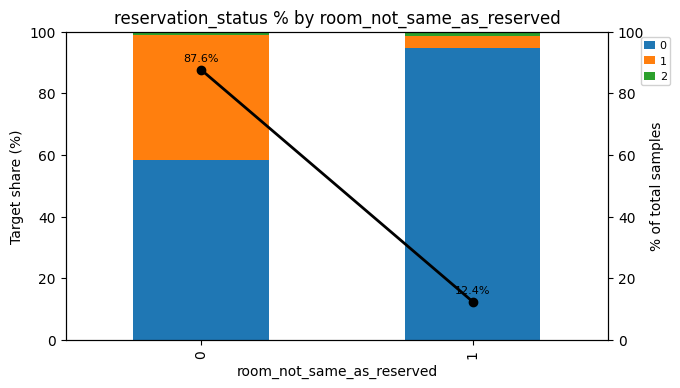

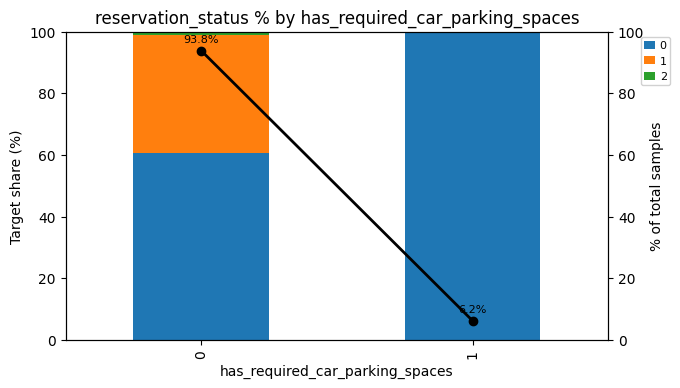

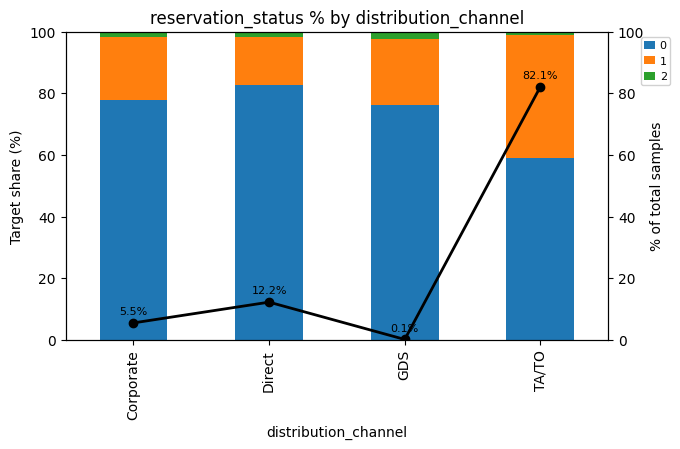

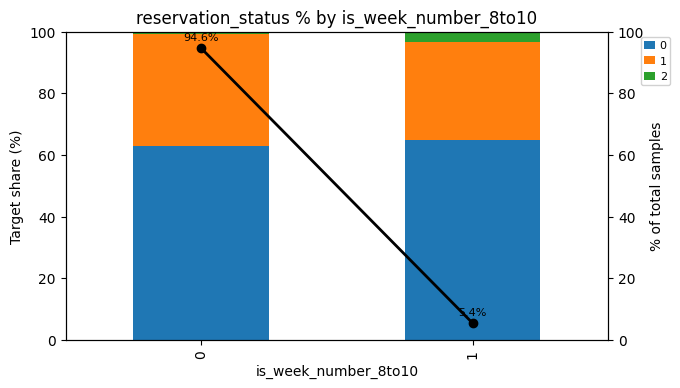

In [14]:
engineered_plots = [
    "is_city_hotel",
    "is_home_country",
    "room_not_same_as_reserved",
    "has_required_car_parking_spaces",
    "distribution_channel",
    "is_week_number_8to10",
]
for col in engineered_plots:
    plot_target_breakdown(df_transformed, col)


In [15]:
df_transformed["adr"].max()


np.float64(451.5)

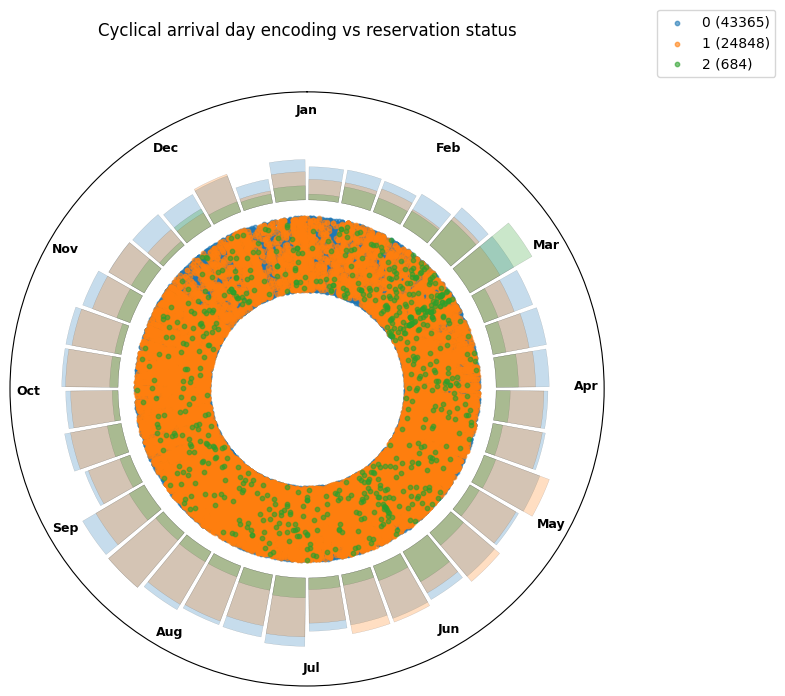

In [16]:
# Seasonality visualization using cyclical encoding of arrival day of year
# Generated with the help of ChatGPT

angle = np.arctan2(
    df_transformed["arrival_day_sin"].values,
    df_transformed["arrival_day_cos"].values,
)
theta = (angle + 2 * np.pi) % (2 * np.pi)
df_transformed["_theta"] = theta

statuses = df_transformed[TARGET_COL].value_counts().index.tolist()
palette = sns.color_palette("tab10", n_colors=max(3, len(statuses)))
colors = {s: palette[i % len(palette)] for i, s in enumerate(statuses)}

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})
ax.set_theta_zero_location("N")  # type:ignore
ax.set_theta_direction(-1)  # type:ignore

for status in statuses:
    subset = df_transformed[df_transformed[TARGET_COL] == status]
    if len(subset) == 0:
        continue
    r = np.random.uniform(0.55, 0.95, size=len(subset))
    ax.scatter(
        subset["_theta"],
        r,
        s=10,
        alpha=0.6,
        color=colors[status],
        label=f"{status} ({len(subset)})",
    )

bins = 36
bar_bottom = 1.05
bar_max_height = 0.4
for status in statuses:
    subset = df_transformed[df_transformed[TARGET_COL] == status]
    counts, bin_edges = np.histogram(subset["_theta"], bins=bins, range=(0, 2 * np.pi))
    if counts.sum() == 0:
        continue
    heights = counts / counts.max() * bar_max_height
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.bar(
        bin_centers,
        heights,
        width=(2 * np.pi / bins) * 0.9,
        bottom=bar_bottom,
        color=colors[status],
        alpha=0.25,
        edgecolor="k",
        linewidth=0.2,
    )

month_ticks = {
    "Jan": 0.0,
    "Feb": 31 / 366 * 2 * np.pi,
    "Mar": (31 + 29) / 366 * 2 * np.pi,
    "Apr": (31 + 29 + 31) / 366 * 2 * np.pi,
    "May": (31 + 29 + 31 + 30) / 366 * 2 * np.pi,
    "Jun": (31 + 29 + 31 + 30 + 31) / 366 * 2 * np.pi,
    "Jul": (31 + 29 + 31 + 30 + 31 + 30) / 366 * 2 * np.pi,
    "Aug": (31 + 29 + 31 + 30 + 31 + 30 + 31) / 366 * 2 * np.pi,
    "Sep": (31 + 29 + 31 + 30 + 31 + 30 + 31 + 31) / 366 * 2 * np.pi,
    "Oct": (31 + 29 + 31 + 30 + 31 + 30 + 31 + 31 + 30) / 366 * 2 * np.pi,
    "Nov": (31 + 29 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31) / 366 * 2 * np.pi,
    "Dec": (31 + 29 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31 + 30) / 366 * 2 * np.pi,
}
for month, ang in month_ticks.items():
    ax.text(ang, 1.55, month, ha="center", va="center", fontsize=9, fontweight="bold")

ax.set_ylim(0, 1.65)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Cyclical arrival day encoding vs reservation status", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.15))

plt.tight_layout()
plt.show()

df_transformed.drop(columns=["_theta"], inplace=True)


In [17]:
cols_to_normalize = [
    "lead_time",
    # "arrival_date_year",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    # "meal",
    # "market_segment",
    # "distribution_channel",
    # "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    # "deposit_type",
    "days_in_waiting_list",
    # "customer_type",
    "adr",
    "total_of_special_requests",
    # "reservation_status",
    # "is_city_hotel",
    # "is_home_country",
    # "room_not_same_as_reserved",
    # "has_required_car_parking_spaces",
    # "arrival_day_sin",
    # "arrival_day_cos",
    # "is_week_number_8to10",
    "reserved_room_type",
    "assigned_room_type",
]

scaler = CustomColumnScaler(columns=cols_to_normalize, exclude=[TARGET_COL])
df_scaled = scaler.fit_transform(df_transformed)
df_scaled.describe().head()

,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,adr,total_of_special_requests,reservation_status,is_city_hotel,is_home_country,room_not_same_as_reserved,has_required_car_parking_spaces,arrival_day_sin,arrival_day_cos,is_week_number_8to10
count,6.889700e+04,68897.000000,6.889700e+04,6.889700e+04,6.889700e+04,6.889700e+04,6.889700e+04,68897.000000,6.889700e+04,6.889700e+04,...,6.889700e+04,6.889700e+04,68897.000000,68897.000000,68897.000000,68897.000000,68897.000000,68897.000000,68897.000000,68897.000000
mean,3.228005e-17,2016.159426,-4.125246e-19,5.197810e-17,4.414014e-17,-5.569083e-17,-5.775345e-18,0.031888,1.546967e-18,-1.237574e-18,...,5.981607e-17,-2.970177e-17,0.380510,0.665791,0.408624,0.124011,0.061701,-0.009974,-0.158900,0.054066
std,1.000007e+00,0.705904,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.175704,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,0.505551,0.471717,0.491583,0.329597,0.240613,0.724238,0.670928,0.226150
min,-9.741330e-01,2015.000000,-9.339862e-01,-1.317363e+00,-3.351567e+00,-2.617977e-01,-7.844519e-02,0.000000,-1.002729e-01,-8.702171e-02,...,-2.113014e+00,-7.207315e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999963,-1.000000,0.000000
25%,-8.058613e-01,2016.000000,-9.339862e-01,-7.897855e-01,2.585626e-01,-2.617977e-01,-7.844519e-02,0.000000,-1.002729e-01,-8.702171e-02,...,-6.623756e-01,-7.207315e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-0.745438,-0.794658,0.000000


In [18]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,68897.0,3.228005e-17,1.000007,-0.974133,-0.805861,-0.329092,0.521615,5.653901
arrival_date_year,68897.0,2.016159e+03,0.705904,2015.000000,2016.000000,2016.000000,2017.000000,2017.000000
stays_in_weekend_nights,68897.0,-4.125246e-19,1.000007,-0.933986,-0.933986,0.069426,1.072839,15.120614
stays_in_week_nights,68897.0,5.197810e-17,1.000007,-1.317363,-0.789786,-0.262208,0.265370,20.313329
adults,68897.0,4.414014e-17,1.000007,-3.351567,0.258563,0.258563,0.258563,86.901684
children,68897.0,-5.569083e-17,1.000007,-0.261798,-0.261798,-0.261798,-0.261798,24.668509
babies,68897.0,-5.775345e-18,1.000007,-0.078445,-0.078445,-0.078445,-0.078445,97.302418
is_repeated_guest,68897.0,3.188818e-02,0.175704,0.000000,0.000000,0.000000,0.000000,1.000000
previous_cancellations,68897.0,1.546967e-18,1.000007,-0.100273,-0.100273,-0.100273,-0.100273,28.699009
previous_bookings_not_canceled,68897.0,-1.237574e-18,1.000007,-0.087022,-0.087022,-0.087022,-0.087022,47.739092
